<a href="https://colab.research.google.com/github/mgnarag/binarization-autoencoder/blob/main/PA3_dropout_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

!ls drive/My\ Drive
file_path = "/content/drive/My Drive/CS284/"

Mounted at /content/drive
'107.1 syllabus 1SAY1920 FINAL.gdoc'
'1C-01 Narag et al (1).pdf'
'1C-01 Narag et al.pdf'
'1FA971504AC646559D05A8ED6341AFB3[1025340].png'
'1H-04 Narag et al.pdf'
 20220802_182749.heic
 20220802_182831.heic
 20220802_183259.heic
 20220803_125819.heic
 20220803_125842.heic
 20220803_144229.heic
 20220803_144422.heic
 20220803_160724.heic
 20220803_160751.heic
 20220803_165240.heic
 20220803_165318.heic
 20220803_174701.heic
 20220803_174706.heic
 20220804_175217.heic
 20220804_175443.heic
 20220804_175616.heic
 20220804_181917.heic
 20220804_182007.heic
 20220804_182117.heic
 2S22-23_LE3-Regular-Set-A-FINAL-KEY.pdf
'A4_Physics 71 TWHFU-3_gradesheet (1).pdf'
'A4_Physics 71 TWHFU-3_officialgrades (1).pdf'
'A4_Physics 71 TWHFU-3_officialgrades.gdoc'
'Abstract - NARAG, Mark Jeremy.pdf'
'Annex 1 (copy of Journal).pdf'
'Annex 2 (Proof of employments).pdf'
'App Physics 181 THY-FX-2_studentcontactlist.xlsx'
 Architectural_designs
'Arki abstract.pdf'
'Arki full paper.pdf'

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
#!pip install torch
import torch
import torch.nn as nn
import cv2

In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

Tesla T4


In [4]:
#Function from the CIFAR website itself:
#I edited it so I can extract the data and label as one
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        data = dict[b'data']
        label = dict[b'labels']
    return data,label

data1,label1 = unpickle(file_path + 'cifar-10-batches-py/data_batch_1')
data2,label2 = unpickle(file_path + 'cifar-10-batches-py/data_batch_2')
data3,label3 = unpickle(file_path + 'cifar-10-batches-py/data_batch_3')
data4,label4 = unpickle(file_path + 'cifar-10-batches-py/data_batch_4')
data5,label5 = unpickle(file_path + 'cifar-10-batches-py/data_batch_5')
data_test,label_test = unpickle(file_path + 'cifar-10-batches-py/test_batch')

#print(label_test.count(9))

## **Pre-processing stage**

Here are the exact steps from the paper:

Each image is of size 32x32, with 3 color channels. We divide the pixel values by 255 to scale them into [0, 1], crop from the center to get 28x28 inputs, and then normalize them by subtracting the mean and dividing the adjusted standard deviation independently for each image with the per_image_whitening function in TENSORFLOW (Abadi et al., 2015).

**Since the data is in 1D, we need to turn 1D vector into the 2D image first:**

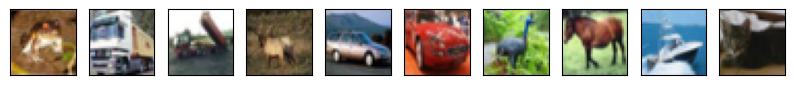

In [5]:
def turn_to_image(data,i):
    #Each data consists of size 3072 which is actually 32 by 32 by 3
    r = np.array(data[i][0:1024]) #extracting the R channel on the first 32 by 32
    g = np.array(data[i][1024:2048]) #extracting the G channel
    b = np.array(data[i][2048:30724]) #extracting the B channel
    r = r.reshape((32, 32)) #Since it is 1D, we resize it to 2D
    g = g.reshape((32, 32))
    b = b.reshape((32, 32))
    rgb = np.stack((r,g,b), axis=-1)
    return rgb

#Let's visualize:
n = 10
plt.figure(figsize=(10, 4))
for i in range(0,10):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow((turn_to_image(data1,i)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### **We divide, crop, and whiten as mentioned:**

 Note that `tf.image.per_image_whitening` does not exist anymore on the latest version of tf so I will just write it.

In [6]:
def divide_crop_norm(data):
    dataset = []
    for i in range(len(data)):
        image = turn_to_image(data,i)
        image = image/255 #dividing by 25
        #since it is from the center with size 28, we can just extract rows and columns from 2 to 30:
        image_crop = image[2:30, 2:30]
        mean = np.mean(image_crop)
        stddev = np.std(image_crop)
        adjusted_stddev = max(stddev, 1.0/len(image_crop.flatten()))
        final_image = (image_crop - mean) / adjusted_stddev
        dataset.append(final_image)
    return dataset

data_image1 = divide_crop_norm(data1)
data_image2 = divide_crop_norm(data2)
data_image3 = divide_crop_norm(data3)
data_image4 = divide_crop_norm(data4)
data_image5 = divide_crop_norm(data5)
data_image_test = divide_crop_norm(data_test)

Now prepping the training and testing data. Actually, we just need to merge the first 5 batches for our training.

In [7]:
training_dataset = np.array(data_image1 + data_image2 + data_image3 + data_image4 + data_image5)
#training_dataset = np.array(data_image1)
training_label = np.array(label1 + label2 + label3 + label4 + label5)
#training_label = np.array(label1)
testing_dataset = np.array(data_image_test)
testing_label = np.array(label_test)

print(np.shape(training_dataset))
print(np.shape(training_label))

(50000, 28, 28, 3)
(50000,)


## **THE MODEL**

**Convolution module:**

In [8]:
class Conv_module(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(Conv_module, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding = 1)
        self.batch_norm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)

        return x

**Inception module:**

In [9]:
class Inception_module(nn.Module):
    def __init__(self, in_channels, out_channels1, out_channels3):
        super(Inception_module, self).__init__()

        # conv module with 1 by 1 filter. This is similar to Conv_module:
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, kernel_size=1, stride = 1)
        self.batch_norm1 = nn.BatchNorm2d(num_features=out_channels1)
        self.relu1 = nn.ReLU(inplace=True)

        # conv module with 3 by 3 filter
        self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels3, kernel_size=3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(num_features=out_channels3)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.batch_norm1(x1)
        x1 = self.relu1(x1)

        x3 = self.conv3(x)
        x3 = self.batch_norm3(x3)
        x3 = self.relu3(x3)
        #print(x1.shape)
        #print(x3.shape)

        # Concatenate the outputs along the channel dimension
        output = torch.cat([x1, x3], dim=1)
        return output

**Down sample module**

In [10]:
class Downsample_module(nn.Module):
    def __init__(self,  in_channels3, out_channels3):
        super(Downsample_module, self).__init__()

        # conv module with 1 by 1 filter. This is similar to Conv_module:
        self.conv3 = nn.Conv2d(in_channels3, out_channels3, kernel_size=3, stride = 2, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(out_channels3)
        self.relu3 = nn.ReLU(inplace=True)

        # max pool with 3 by 3 filter and 2 by 2 strides
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)

    def forward(self, x):
        x3 = self.conv3(x)
        x3 = self.batch_norm3(x3)
        x3 = self.relu3(x3)

        max_pooled = self.max_pool(x)

        #print(x3.shape)
        #print(max_pooled.shape)

        output = torch.cat([x3, max_pooled], dim=1)
        return output

**Fully connected**

In [11]:
class Fully_connected(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,p):
        super(Fully_connected, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


**Mini GoogLeNet model:**

In [12]:
class miniGoogLeNet(nn.Module):
    def __init__(self, dropout_rate):
        super(miniGoogLeNet, self).__init__()
        self.Conv_1 = Conv_module(in_channels=3, out_channels=96, kernel_size=3, stride=1)
        self.Inception_2 = Inception_module(in_channels = 96, out_channels1 = 32, out_channels3 = 32)
        self.Inception_3 = Inception_module(in_channels = 64, out_channels1 = 32, out_channels3 = 48)
        self.DownSample_4 = Downsample_module(in_channels3 = 80, out_channels3=80)
        self.Inception_5 = Inception_module(in_channels = 160, out_channels1 = 112, out_channels3 = 48)
        self.Inception_6 = Inception_module(in_channels = 160, out_channels1 = 96, out_channels3 = 64)
        self.Inception_7 = Inception_module(in_channels = 160, out_channels1 = 80, out_channels3 = 80)
        self.Inception_8 = Inception_module(in_channels = 160, out_channels1 = 48, out_channels3 = 96)
        self.DownSample_9 = Downsample_module(in_channels3 = 144, out_channels3=96)
        self.Inception_10 = Inception_module(in_channels = 240, out_channels1 = 176, out_channels3 = 160)
        self.Inception_11 = Inception_module(in_channels = 336, out_channels1 = 176, out_channels3 = 160)
        self.meanpool_12 = nn.AvgPool2d(kernel_size=7)

        self.fc13 = Fully_connected(input_size=336, hidden_size=512, output_size=10,p=dropout_rate)

    def forward(self, x):
        x = self.Conv_1(x)
        #print("done 1")
        x = self.Inception_2(x)
        #print("done 2")
        x = self.Inception_3(x)
        #print("done 3")
        x = self.DownSample_4(x)
        #print("done 4")
        x = self.Inception_5(x)
        #print("done 5")
        x = self.Inception_6(x)
        #print("done 6")
        x = self.Inception_7(x)
        #print("done 7")
        x = self.Inception_8(x)
        #print("done 8")
        x = self.DownSample_9(x)
        #print("done 9")
        x = self.Inception_10(x)
        #print("done 10")
        x = self.Inception_11(x)
        #print("done 11", x.shape)
        x = self.meanpool_12(x)
        #print("done 12", x.shape)
        x = self.fc13(x)
        #print("done 13")

        return x

In [13]:
#from torchsummary import summary

#model = miniGoogLeNet(dropout_rate).cuda()
#model_summary = summary(model, (3,28,28), device='cuda')
#print(model_summary)

In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import pandas as pd
import time
from torch.utils.data import DataLoader, random_split

batch_size = 8

training_dataset_transpose = training_dataset.transpose(0, 3, 1, 2)
inputs_tensor = torch.tensor(training_dataset_transpose, dtype=torch.float32) # Convert NumPy arrays to PyTorch tensors


train_dataset = inputs_tensor[:40000]
val_dataset = inputs_tensor[40000:]

#for the labels:
labels_tensor = torch.tensor(training_label).to(device)
labels_tensor = torch.unsqueeze(labels_tensor, dim=1)
labels_tensor = torch.round(labels_tensor).to(torch.int).to(torch.int64)
train_labels = labels_tensor[:40000]
val_labels = labels_tensor[40000:]

# Create a TensorDataset
dataset = TensorDataset(train_dataset, train_labels)
# Create a DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create a TensorDataset
val_dataset = TensorDataset(val_dataset, val_labels)
# Create a DataLoader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:



# Hyperparameters
learning_rate = 0.01
dropout_rate = 0.5
epochs = 80


model = miniGoogLeNet(dropout_rate)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def linear_decay(epoch):
    decay_factor = 1.0 - epoch / epochs
    return decay_factor


# Create model, optimizer, and scheduler
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = LambdaLR(optimizer, lr_lambda=linear_decay)

# Loss function
criterion = nn.CrossEntropyLoss()



# Set the model in training mode
model.train()
# Training loop

losses = []
val_accuracies = []

# Record the start time
start_time = time.time()
for epoch in range(epochs):

  for batch in train_loader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        #print(batch[0].shape)
        #print(batch[1])

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        #print("outputs=",outputs)
        #print("labels=",labels)
        #print(labels.dtype)

        # Compute loss
        loss = F.cross_entropy(outputs, labels.squeeze(dim=1))

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        # Save the loss value



        # Adjust the learning rate
  scheduler.step()
  losses.append(loss.item())


  # Validation
  model.eval()
  correct = 0

  with torch.no_grad():
      for batch_val in val_loader:
        inputs_val, labels_val = batch_val[0].to(device), batch_val[1].to(device)
        outputs_val = model(inputs_val)
        _, predicted = torch.max(outputs_val, 1)
        correct += (predicted == labels).sum().item()

  # Calculate validation accuracy for the epoch
  val_accuracy = correct / 10000
  val_accuracies.append(val_accuracy)

  print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {loss.item():.6f}, Validation Accuracy: {val_accuracy:.6f}')

# Record the end time
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Convert the training duration to a string representation
training_text = str(training_time)

# Specify the file path
x = file_path + 'training_duration_'+ str(dropout_rate)+'.txt'

# Write the training duration to a text file
with open(x, 'w') as file:
    file.write(training_text)

# Save the losses to a CSV file
losses_df = pd.DataFrame(losses, columns=['loss'])
losses_df.to_csv(file_path + 'losses_'+str(dropout_rate)+'.csv', index=False)

# Save the losses to a CSV file
val_accuracies_df = pd.DataFrame(val_accuracies)
val_accuracies_df.to_csv(file_path + 'val_accuracies_'+str(dropout_rate)+'.csv', index=False)

# Save the trained model
torch.save(model.state_dict(), file_path + 'model_'+str(dropout_rate)+'.pth')

Epoch [1/80], Training Loss: 1.870666, Validation Accuracy: 0.919100
Epoch [2/80], Training Loss: 0.563441, Validation Accuracy: 0.972800
Epoch [3/80], Training Loss: 1.383907, Validation Accuracy: 0.870800
Epoch [4/80], Training Loss: 0.375706, Validation Accuracy: 0.785500
Epoch [5/80], Training Loss: 0.426451, Validation Accuracy: 0.840300
Epoch [6/80], Training Loss: 0.805660, Validation Accuracy: 0.783000
Epoch [7/80], Training Loss: 0.046889, Validation Accuracy: 0.866300
Epoch [8/80], Training Loss: 0.820671, Validation Accuracy: 0.772500
Epoch [9/80], Training Loss: 0.460400, Validation Accuracy: 0.841100
Epoch [10/80], Training Loss: 0.831165, Validation Accuracy: 0.730100
Epoch [11/80], Training Loss: 0.303120, Validation Accuracy: 0.858900
Epoch [12/80], Training Loss: 0.068505, Validation Accuracy: 0.753600
Epoch [13/80], Training Loss: 0.061698, Validation Accuracy: 0.890400
Epoch [14/80], Training Loss: 0.135567, Validation Accuracy: 0.796700
Epoch [15/80], Training Loss:

## **Testing the model**

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import pandas as pd
import time

# Load the saved model


loaded_model = miniGoogLeNet(dropout_rate)
loaded_model.load_state_dict(torch.load(file_path + 'model_'+str(dropout_rate)+'.pth'))
loaded_model.eval()  # Set the model to evaluation mode


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

testing_dataset_transpose = testing_dataset.transpose(0, 3, 1, 2)
# Convert NumPy arrays to PyTorch tensors
inputs_tensor = torch.tensor(testing_dataset_transpose, dtype=torch.float32)

#for the labels:
labels_tensor = torch.tensor(testing_label).to(device)
labels_tensor = torch.unsqueeze(labels_tensor, dim=1)
labels_tensor = torch.round(labels_tensor).to(torch.int).to(torch.int64)


# Create a TensorDataset
dataset = TensorDataset(inputs_tensor, labels_tensor)
# Create a DataLoader
test_loader = DataLoader(dataset, batch_size=8, shuffle=True)


In [17]:
predictions, targets = [], []
for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    logps = model(images)
    output = torch.exp(logps)
    pred = torch.argmax(output, 1)

    # convert to numpy arrays
    pred = pred.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    for i in range(len(pred)):
        predictions.append(pred[i])
        targets.append(labels[i])

Normalized confusion matrix
[[0.872 0.009 0.027 0.015 0.006 0.003 0.01  0.008 0.04  0.01 ]
 [0.009 0.925 0.003 0.003 0.001 0.003 0.002 0.002 0.01  0.042]
 [0.046 0.001 0.762 0.042 0.05  0.043 0.037 0.01  0.006 0.003]
 [0.019 0.003 0.044 0.719 0.04  0.109 0.037 0.016 0.007 0.006]
 [0.007 0.001 0.031 0.032 0.855 0.029 0.021 0.021 0.003 0.   ]
 [0.006 0.001 0.031 0.105 0.021 0.782 0.019 0.034 0.001 0.   ]
 [0.005 0.    0.034 0.048 0.022 0.016 0.863 0.003 0.007 0.002]
 [0.008 0.    0.012 0.037 0.027 0.025 0.003 0.883 0.002 0.003]
 [0.046 0.013 0.005 0.008 0.002 0.002 0.005 0.001 0.901 0.017]
 [0.018 0.032 0.004 0.009 0.002 0.    0.003 0.004 0.022 0.906]]


<Figure size 640x480 with 0 Axes>

<Figure size 20000x20000 with 0 Axes>

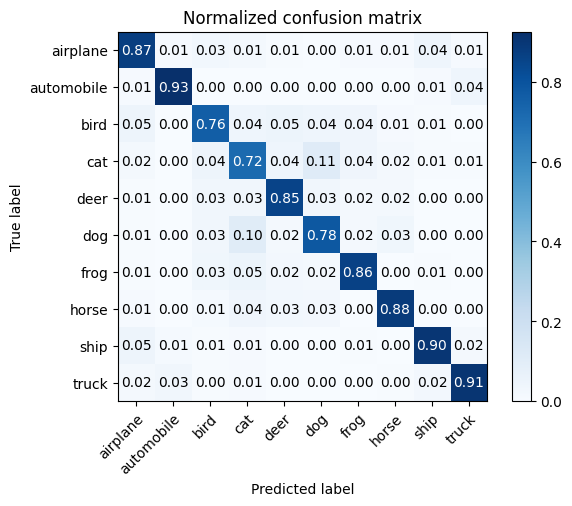

In [18]:
# import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

classes = ("airplane", "automobile","bird", "cat","deer",
                               "dog", "frog","horse","ship", "truck")

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#    fig.tight_layout()
    return ax
plt.figure()
plt.figure(figsize=(200, 200))
plot_confusion_matrix(targets, predictions, classes=classes,  normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(file_path + 'CM Normalized with dropout and validation_'+str(dropout_rate)+'.png')
plt.show()

In [19]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(targets, predictions)
print(f"Accuracy: {accuracy:.4f}")
accuracy_str = str(accuracy)

# Specify the file path
file_path = file_path + 'accuracy_'+ str(dropout_rate)+'.txt'

# Write the training duration to a text file
with open(file_path, 'w') as file:
    file.write(accuracy_str)

Accuracy: 0.8468
